In [1]:
import re
import torch
import collections
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, TensorDataset

# 1. 概念

想象一下有人正在看网飞（Netflix，一个国外的视频网站）上的电影。
一名忠实的用户会对每一部电影都给出评价，
毕竟一部好电影需要更多的支持和认可。
然而事实证明，事情并不那么简单。
随着时间的推移，人们对电影的看法会发生很大的变化。
事实上，心理学家甚至对这些现象起了名字：

* *锚定*（anchoring）效应：基于其他人的意见做出评价。
  例如，奥斯卡颁奖后，受到关注的电影的评分会上升，尽管它还是原来那部电影。
  这种影响将持续几个月，直到人们忘记了这部电影曾经获得的奖项。
  结果表明这种效应会使评分提高半个百分点以上。
* *享乐适应*（hedonic adaption）：人们迅速接受并且适应一种更好或者更坏的情况
  作为新的常态。
  例如，在看了很多好电影之后，人们会强烈期望下部电影会更好。
  因此，在许多精彩的电影被看过之后，即使是一部普通的也可能被认为是糟糕的。
* *季节性*（seasonality）：少有观众喜欢在八月看圣诞老人的电影。
* 有时，电影会由于导演或演员在制作中的不当行为变得不受欢迎。
* 有些电影因为其极度糟糕只能成为小众电影。*Plan9from Outer Space*和*Troll2*就因为这个原因而臭名昭著的。

简而言之，电影评分决不是固定不变的。
因此，使用时间动力学可以得到更准确的电影推荐。
当然，序列数据不仅仅是关于电影评分的。
下面给出了更多的场景。

* 在使用程序时，许多用户都有很强的特定习惯。
  例如，在学生放学后社交媒体应用更受欢迎。在市场开放时股市交易软件更常用。
* 预测明天的股价要比过去的股价更困难，尽管两者都只是估计一个数字。
  毕竟，先见之明比事后诸葛亮难得多。
  在统计学中，前者（对超出已知观测范围进行预测）称为*外推法*（extrapolation），
  而后者（在现有观测值之间进行估计）称为*内插法*（interpolation）。
* 在本质上，音乐、语音、文本和视频都是连续的。
  如果它们的序列被我们重排，那么就会失去原有的意义。
  比如，一个文本标题“狗咬人”远没有“人咬狗”那么令人惊讶，尽管组成两句话的字完全相同。
* 地震具有很强的相关性，即大地震发生后，很可能会有几次小余震，
  这些余震的强度比非大地震后的余震要大得多。
  事实上，地震是时空相关的，即余震通常发生在很短的时间跨度和很近的距离内。
* 人类之间的互动也是连续的，这可以从微博上的争吵和辩论中看出。

**统计工具**

处理序列数据需要统计工具和新的深度神经网络架构。
为了简单起见，以下图所示的股票价格（富时100指数）为例。

![近30年的富时100指数](../img/ftse100.png)

其中，用$x_t$表示价格，即在*时间步*（time step）
$t \in \mathbb{Z}^+$时，观察到的价格$x_t$。
请注意，$t$对于本文中的序列通常是离散的，并在整数或其子集上变化。
假设一个交易员想在$t$日的股市中表现良好，于是通过以下途径预测$x_t$：

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

**自回归模型**

为了实现这个预测，交易员可以使用回归模型，比如说线性回归。
仅有一个主要问题：输入数据的数量，
输入$x_{t-1}, \ldots, x_1$本身因$t$而异。
也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，
因此需要一个近似方法来使这个计算变得容易处理。
本章后面的大部分内容将围绕着如何有效估计
$P(x_t \mid x_{t-1}, \ldots, x_1)$展开。
简单地说，它归结为以下两种策略。

第一种策略，假设在现实情况下相当长的序列
$x_{t-1}, \ldots, x_1$可能是不必要的，
因此我们只需要满足某个长度为$\tau$的时间跨度，
即使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$。
当下获得的最直接的好处就是参数的数量总是不变的，
至少在$t > \tau$时如此，这就使我们能够训练一个上面提及的深度网络。
这种模型被称为*自回归模型*（autoregressive models），
因为它们是对自己执行回归。

第二种策略，如下图所示，
是保留一些对过去观测的总结$h_t$，
并且同时更新预测$\hat{x}_t$和总结$h_t$。
这就产生了基于$\hat{x}_t = P(x_t \mid h_{t})$估计$x_t$，
以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。
由于$h_t$从未被观测到，这类模型也被称为
*隐变量自回归模型*（latent autoregressive models）。

![隐变量自回归模型](../img/sequence-model.svg)

这两种情况都有一个显而易见的问题：如何生成训练数据？
一个经典方法是使用历史观测来预测下一个未来观测。
显然，我们并不指望时间会停滞不前。
然而，一个常见的假设是虽然特定值$x_t$可能会改变，
但是序列本身的动力学不会改变。
这样的假设是合理的，因为新的动力学一定受新的数据影响，
而我们不可能用目前所掌握的数据来预测新的动力学。
统计学家称不变的动力学为*静止的*（stationary）。
因此，整个序列的估计值都将通过以下的方式获得：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

注意，如果我们处理的是离散的对象（如单词），
而不是连续的数字，则上述的考虑仍然有效。
唯一的差别是，对于离散的对象，
我们需要使用分类器而不是回归模型来估计$P(x_t \mid  x_{t-1}, \ldots, x_1)$。

**马尔可夫模型**

回想一下，在自回归模型的近似法中，
我们使用$x_{t-1}, \ldots, x_{t-\tau}$
而不是$x_{t-1}, \ldots, x_1$来估计$x_t$。
只要这种是近似精确的，我们就说序列满足*马尔可夫条件*（Markov condition）。
特别是，如果$\tau = 1$，得到一个
*一阶马尔可夫模型*（first-order Markov model），
$P(x)$由下式给出：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).$$

当假设$x_t$仅是离散值时，这样的模型特别棒，
因为在这种情况下，使用动态规划可以沿着马尔可夫链精确地计算结果。
例如，我们可以高效地计算$P(x_{t+1} \mid x_{t-1})$：

$$
\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

利用这一事实，我们只需要考虑过去观察中的一个非常短的历史：
$P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$。

**因果关系**

原则上，将$P(x_1, \ldots, x_T)$倒序展开也没什么问题。
毕竟，基于条件概率公式，我们总是可以写出：

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

事实上，如果基于一个马尔可夫模型，
我们还可以得到一个反向的条件概率分布。
然而，在许多情况下，数据存在一个自然的方向，即在时间上是前进的。
很明显，未来的事件不能影响过去。
因此，如果我们改变$x_t$，可能会影响未来发生的事情$x_{t+1}$，但不能反过来。
也就是说，如果我们改变$x_t$，基于过去事件得到的分布不会改变。
因此，解释$P(x_{t+1} \mid x_t)$应该比解释$P(x_t \mid x_{t+1})$更容易。
例如，在某些情况下，对于某些可加性噪声$\epsilon$，
显然我们可以找到$x_{t+1} = f(x_t) + \epsilon$，
而反之则不行 :cite:`Hoyer.Janzing.Mooij.ea.2009`。
而这个向前推进的方向恰好也是我们通常感兴趣的方向。
彼得斯等人 :cite:`Peters.Janzing.Scholkopf.2017`
对该主题的更多内容做了详尽的解释，而我们的上述讨论只是其中的冰山一角。

# 2. 简单的示例

## 2.1 数据构造

在了解了上述统计工具后，让我们在实践中尝试一下！
首先，我们生成一些数据：(**使用正弦函数和一些可加性噪声来生成序列数据，
时间步为$1, 2, \ldots, 1000$。**)

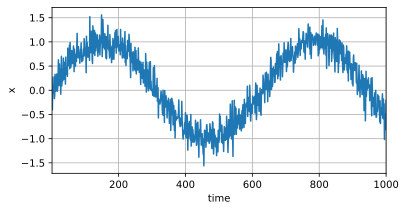

In [2]:
import torch
from torch import nn
import d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的*特征－标签*（feature-label）对。
基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。


In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

# 使用一个相当简单的架构训练模型：一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

## 2.2 训练

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.061844
epoch 2, loss: 0.056514
epoch 3, loss: 0.053558
epoch 4, loss: 0.050670
epoch 5, loss: 0.051192


## 2.3 预测

由于训练损失很小，因此我们期望模型能有很好的工作效果。
让我们看看这在实践中意味着什么。
首先是检查[**模型预测下一个时间步**]的能力，
也就是*单步预测*（one-step-ahead prediction）。

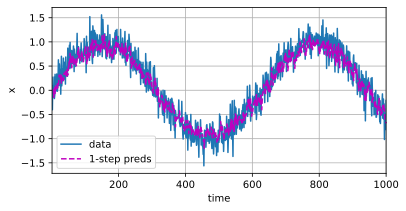

In [5]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

正如我们所料，单步预测效果不错。
即使这些预测的时间步超过了$600+4$（`n_train + tau`），
其结果看起来仍然是可信的。
然而有一个小问题：如果数据观察序列的时间步只到$604$，
我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。
让我们看看效果如何。


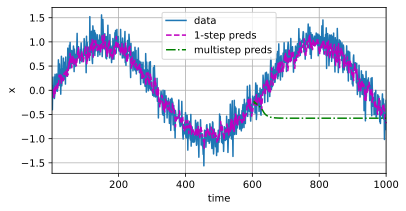

In [6]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
为什么这个算法效果这么差呢？事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。
于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。
因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，
但超过这一点，精度就会迅速下降。

# 3. 文本预处理

## 3.1 读取数据集

首先，我们从H.G.Well的[时光机器](https://www.gutenberg.org/ebooks/35)中加载文本。
这是一个相当小的语料库，只有30000多个单词，但足够我们小试牛刀，
而现实中的文档集合可能会包含数十亿个单词。
下面的函数(**将数据集读取到由多条文本行组成的列表中**)，其中每条文本行都是一个字符串。
为简单起见，我们在这里忽略了标点符号和字母大写。

In [7]:
def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open('../data/timemachine.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 3.2 词元化（tokenize）

下面的`tokenize`函数将文本行列表（`lines`）作为输入，
列表中的每个元素是一个文本序列（如一条文本行）。
[**每个文本序列又被拆分成一个词元列表**]，*词元*（token）是文本的基本单位。
最后，返回一个由词元列表组成的列表，其中的每个词元都是一个字符串（string）。

In [8]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## 3.3 词表

词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。
现在，让我们[**构建一个字典，通常也叫做*词表*（vocabulary），
用来将字符串类型的词元映射到从$0$开始的数字索引中**]。
我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计，
得到的统计结果称之为*语料*（corpus）。
然后根据每个唯一词元的出现频率，为其分配一个数字索引。
很少出现的词元通常被移除，这可以降低复杂性。
另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“&lt;unk&gt;”。
我们可以选择增加一个列表，用于保存那些被保留的词元，
例如：填充词元（“&lt;pad&gt;”）；
序列开始词元（“&lt;bos&gt;”）；
序列结束词元（“&lt;eos&gt;”）。


In [9]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [10]:
# 现在，我们可以将每一条文本行转换成一个数字索引列表
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])
    print()

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]

文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]



## 3.4 整合所有功能

在使用上述函数时，我们[**将所有功能打包到`load_corpus_time_machine`函数中**]，
该函数返回`corpus`（词元索引列表）和`vocab`（时光机器语料库的词表）。
我们在这里所做的改变是：

1. 为了简化后面章节中的训练，我们使用字符（而不是单词）实现文本词元化；
1. 时光机器数据集中的每个文本行不一定是一个句子或一个段落，还可能是一个单词，因此返回的`corpus`仅处理为单个列表，而不是使用多词元列表构成的一个列表。

In [11]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

# 4. 语言模型和数据集

假设长度为$T$的文本序列中的词元依次为$x_1, x_2, \ldots, x_T$。
于是，$x_t$（$1 \leq t \leq T$）
可以被认为是文本序列在时间步$t$处的观测或标签。
在给定这样的文本序列时，*语言模型*（language model）的目标是估计序列的联合概率

$$P(x_1, x_2, \ldots, x_T).$$

例如，只需要一次抽取一个词元$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$，
一个理想的语言模型就能够基于模型本身生成自然文本。
与猴子使用打字机完全不同的是，从这样的模型中提取的文本
都将作为自然语言（例如，英语文本）来传递。
只需要基于前面的对话片断中的文本，
就足以生成一个有意义的对话。
显然，我们离设计出这样的系统还很遥远，
因为它需要“理解”文本，而不仅仅是生成语法合理的内容。

尽管如此，语言模型依然是非常有用的。
例如，短语“to recognize speech”和“to wreck a nice beach”读音上听起来非常相似。
这种相似性会导致语音识别中的歧义，但是这很容易通过语言模型来解决，
因为第二句的语义很奇怪。
同样，在文档摘要生成算法中，
“狗咬人”比“人咬狗”出现的频率要高得多，
或者“我想吃奶奶”是一个相当匪夷所思的语句，
而“我想吃，奶奶”则要正常得多。

**学习语言模型**

显而易见，我们面对的问题是如何对一个文档，
甚至是一个词元序列进行建模。
假设在单词级别对文本数据进行词元化，从基本概率规则开始：

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

例如，包含了四个单词的一个文本序列的概率是：

$$P(\text{deep}, \text{learning}, \text{is}, \text{fun}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{is}  \mid  \text{deep}, \text{learning}) P(\text{fun}  \mid  \text{deep}, \text{learning}, \text{is}).$$

为了训练语言模型，我们需要计算单词的概率，
以及给定前面几个单词后出现某个单词的条件概率。
这些概率本质上就是语言模型的参数。

这里，我们假设训练数据集是一个大型的文本语料库。
比如，维基百科的所有条目、古登堡计划或者所有发布在网络上的文本。
训练数据集中词的概率可以根据给定词的相对词频来计算。
例如，可以将估计值$\hat{P}(\text{deep})$
计算为任何以单词“deep”开头的句子的概率。
一种（稍稍不太精确的）方法是统计单词“deep”在数据集中的出现次数，
然后将其除以整个语料库中的单词总数。
这种方法效果不错，特别是对于频繁出现的单词。
接下来，我们可以尝试估计

$$\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},$$

其中$n(x)$和$n(x, x')$分别是单个单词和连续单词对的出现次数。
不幸的是，由于连续单词对“deep learning”的出现频率要低得多，
所以估计这类单词正确的概率要困难得多。
特别是对于一些不常见的单词组合，要想找到足够的出现次数来获得准确的估计可能都不容易。
而对于三个或者更多的单词组合，情况会变得更糟。
许多合理的三个单词组合可能是存在的，但是在数据集中却找不到。
除非我们提供某种解决方案，来将这些单词组合指定为非零计数，
否则将无法在语言模型中使用它们。
如果数据集很小，或者单词非常罕见，那么这类单词出现一次的机会可能都找不到。

一种常见的策略是执行某种形式的*拉普拉斯平滑*（Laplace smoothing），
具体方法是在所有计数中添加一个小常量。
用$n$表示训练集中的单词总数，用$m$表示唯一单词的数量。
此解决方案有助于处理单元素问题，例如通过：

$$
\begin{aligned}
    \hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
    \hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
    \hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}
$$

其中，$\epsilon_1,\epsilon_2$和$\epsilon_3$是超参数。
以$\epsilon_1$为例：当$\epsilon_1 = 0$时，不应用平滑；
当$\epsilon_1$接近正无穷大时，$\hat{P}(x)$接近均匀概率分布$1/m$。
上面的公式是 :cite:`Wood.Gasthaus.Archambeau.ea.2011`
的一个相当原始的变形。

然而，这样的模型很容易变得无效，原因如下：
首先，我们需要存储所有的计数；
其次，这完全忽略了单词的意思。
例如，“猫”（cat）和“猫科动物”（feline）可能出现在相关的上下文中，
但是想根据上下文调整这类模型其实是相当困难的。
最后，长单词序列大部分是没出现过的，
因此一个模型如果只是简单地统计先前“看到”的单词序列频率，
那么模型面对这种问题肯定是表现不佳的。

**马尔可夫模型与$n$元语法**

在讨论包含深度学习的解决方案之前，我们需要了解更多的概念和术语。
如果$P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$，
则序列上的分布满足一阶马尔可夫性质。
阶数越高，对应的依赖关系就越长。
这种性质推导出了许多可以应用于序列建模的近似公式：

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

通常，涉及一个、两个和三个变量的概率公式分别被称为
*一元语法*（unigram）、*二元语法*（bigram）和*三元语法*（trigram）模型。
下面，我们将学习如何去设计更好的模型。

**自然语言统计**

我们看看在真实数据上如果进行自然语言统计。
根据时光机器数据集构建词表，
并打印前$10$个最常用的（频率最高的）单词。

In [12]:
tokens = tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，(**最流行的词**)看起来很无聊，
这些词通常(**被称为*停用词***)（stop words），因此可以被过滤掉。
尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。
此外，还有个明显的问题是词频衰减的速度相当地快。
例如，最常用单词的词频对比，第$10$个还不到第$1$个的$1/5$。
为了更好地理解，我们可以[**画出的词频图**]：


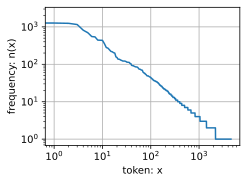

In [13]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

通过此图我们可以发现：词频以一种明确的方式迅速衰减。
将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。
这意味着单词的频率满足*齐普夫定律*（Zipf's law），
即第$i$个最常用单词的频率$n_i$为：

$$n_i \propto \frac{1}{i^\alpha},$$

等价于

$$\log n_i = -\alpha \log i + c,$$

其中$\alpha$是刻画分布的指数，$c$是常数。
这告诉我们想要通过计数统计和平滑来建模单词是不可行的，
因为这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用单词。
那么[**其他的词元组合，比如二元语法、三元语法等等，又会如何呢？**]
我们来看看二元语法的频率是否与一元语法的频率表现出相同的行为方式。

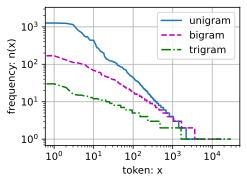

In [14]:
# 二元语法
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)

# 三元语法
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)

bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

这张图非常令人振奋！原因有很多：

1. 除了一元语法词，单词序列似乎也遵循齐普夫定律
2. 词表中$n$元组的数量并没有那么大，这说明语言中存在相当多的结构，
这些结构给了我们应用模型的希望；
3. 很多$n$元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。
作为代替，我们将使用基于深度学习的模型。

**读取长序列数据**

由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。

当序列变得太长而不能被模型一次性全部处理时，
我们可能希望拆分这样的序列方便模型读取。

在介绍该模型之前，我们看一下总体策略。
假设我们将使用神经网络来训练语言模型，
模型中的网络一次处理具有预定义长度
（例如$n$个时间步）的一个小批量序列。
现在的问题是如何[**随机生成一个小批量数据的特征和标签以供读取。**]

首先，由于文本序列可以是任意长的，
例如整本《时光机器》（*The Time Machine*），
于是任意长的序列可以被我们划分为具有相同时间步数的子序列。
当训练我们的神经网络时，这样的小批量子序列将被输入到模型中。
假设网络一次只处理具有$n$个时间步的子序列。

从原始文本序列获得子序列的所有不同的方式，
其中$n=5$，并且每个时间步的词元对应于一个字符。
请注意，因为我们可以选择任意偏移量来指示初始位置，所以我们有相当大的自由度。

![分割文本时，不同的偏移量会导致不同的子序列](../img/timemachine-5gram.svg)

因此，我们应该选择哪一个呢？
事实上，他们都一样的好。
然而，如果我们只选择一个偏移量，
那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的。
因此，我们可以从随机偏移量开始划分序列，
以同时获得*覆盖性*（coverage）和*随机性*（randomness）。
下面，我们将描述如何实现*随机采样*（random sampling）和
*顺序分区*（sequential partitioning）策略。

**随机采样**

(**在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。**)
在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。
对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元，
因此标签是移位了一个词元的原始序列。

下面的代码每次可以从数据中随机生成一个小批量。
在这里，参数`batch_size`指定了每个小批量中子序列样本的数目，
参数`num_steps`是每个子序列中预定义的时间步数。


In [15]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

下面我们[**生成一个从$0$到$34$的序列**]。假设批量大小为$2$，时间步数为$5$，这意味着可以生成
$\lfloor (35 - 1) / 5 \rfloor= 6$个“特征－标签”子序列对。
如果设置小批量大小为$2$，我们只能得到$3$个小批量。

In [16]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[25, 26, 27, 28, 29],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[26, 27, 28, 29, 30],
        [ 6,  7,  8,  9, 10]])
X:  tensor([[15, 16, 17, 18, 19],
        [ 0,  1,  2,  3,  4]]) 
Y: tensor([[16, 17, 18, 19, 20],
        [ 1,  2,  3,  4,  5]])
X:  tensor([[20, 21, 22, 23, 24],
        [10, 11, 12, 13, 14]]) 
Y: tensor([[21, 22, 23, 24, 25],
        [11, 12, 13, 14, 15]])


# 5. 循环神经网络

## 5.1 网络结构

$n$元语法模型，其中单词$x_t$在时间步$t$的条件概率仅取决于前面$n-1$个单词。
对于时间步$t-(n-1)$之前的单词，
如果我们想将其可能产生的影响合并到$x_t$上，
需要增加$n$，然而模型参数的数量也会随之呈指数增长，
因为词表$\mathcal{V}$需要存储$|\mathcal{V}|^n$个数字，
因此与其将$P(x_t \mid x_{t-1}, \ldots, x_{t-n+1})$模型化，
不如使用隐变量模型：

$$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),$$

其中$h_{t-1}$是*隐状态*（hidden state），
也称为*隐藏变量*（hidden variable），
它存储了到时间步$t-1$的序列信息。
通常，我们可以基于当前输入$x_{t}$和先前隐状态$h_{t-1}$
来计算时间步$t$处的任何时间的隐状态：

$$h_t = f(x_{t}, h_{t-1}).$$

对于函数$f$，隐变量模型不是近似值。
毕竟$h_t$是可以仅仅存储到目前为止观察到的所有数据，
然而这样的操作可能会使计算和存储的代价都变得昂贵。

值得注意的是，隐藏层和隐状态指的是两个截然不同的概念。
如上所述，隐藏层是在从输入到输出的路径上（以观测角度来理解）的隐藏的层，
而隐状态则是在给定步骤所做的任何事情（以技术角度来定义）的*输入*，
并且这些状态只能通过先前时间步的数据来计算。

*循环神经网络*（recurrent neural networks，RNNs）
是具有隐状态的神经网络。

**无隐状态的神经网络**

让我们来看一看只有单隐藏层的多层感知机。
设隐藏层的激活函数为$\phi$，
给定一个小批量样本$\mathbf{X} \in \mathbb{R}^{n \times d}$，
其中批量大小为$n$，输入维度为$d$，
则隐藏层的输出$\mathbf{H} \in \mathbb{R}^{n \times h}$通过下式计算：

$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h).$$

隐藏层权重参数为$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$，
偏置参数为$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$，
以及隐藏单元的数目为$h$。
因此求和时可以应用广播机制。
接下来，将隐藏变量$\mathbf{H}$用作输出层的输入。
输出层由下式给出：

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q,$$

其中，$\mathbf{O} \in \mathbb{R}^{n \times q}$是输出变量，
$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$是权重参数，
$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$是输出层的偏置参数。
如果是分类问题，我们可以用$\text{softmax}(\mathbf{O})$
来计算输出类别的概率分布。

只要可以随机选择“特征-标签”对，
并且通过自动微分和随机梯度下降能够学习网络参数就可以了。

**有隐状态的循环神经网络**

有了隐状态后，情况就完全不同了。
假设我们在时间步$t$有小批量输入$\mathbf{X}_t \in \mathbb{R}^{n \times d}$。
换言之，对于$n$个序列样本的小批量，
$\mathbf{X}_t$的每一行对应于来自该序列的时间步$t$处的一个样本。
接下来，用$\mathbf{H}_t  \in \mathbb{R}^{n \times h}$
表示时间步$t$的隐藏变量。
与多层感知机不同的是，
我们在这里保存了前一个时间步的隐藏变量$\mathbf{H}_{t-1}$，
并引入了一个新的权重参数$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$，
来描述如何在当前时间步中使用前一个时间步的隐藏变量。
具体地说，当前时间步隐藏变量由当前时间步的输入
与前一个时间步的隐藏变量一起计算得出：

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

多添加了一项
$\mathbf{H}_{t-1} \mathbf{W}_{hh}$

从相邻时间步的隐藏变量$\mathbf{H}_t$和
$\mathbf{H}_{t-1}$之间的关系可知，
这些变量捕获并保留了序列直到其当前时间步的历史信息，
就如当前时间步下神经网络的状态或记忆，
因此这样的隐藏变量被称为*隐状态*（hidden state）。
由于在当前时间步中，
隐状态使用的定义与前一个时间步中使用的定义相同，
因此计算是*循环的*（recurrent）。
于是基于循环计算的隐状态神经网络被命名为
*循环神经网络*（recurrent neural network）。
在循环神经网络中执行计算的层
称为*循环层*（recurrent layer）。

对于时间步$t$，输出层的输出类似于多层感知机中的计算：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

循环神经网络的参数包括隐藏层的权重
$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$和偏置$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$，
以及输出层的权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$
和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$。
值得一提的是，即使在不同的时间步，循环神经网络也总是使用这些模型参数。
因此，循环神经网络的参数开销不会随着时间步的增加而增加。

在任意时间步$t$，隐状态的计算可以被视为：

1. 拼接当前时间步$t$的输入$\mathbf{X}_t$和前一时间步$t-1$的隐状态$\mathbf{H}_{t-1}$；
1. 将拼接的结果送入带有激活函数$\phi$的全连接层。
   全连接层的输出是当前时间步$t$的隐状态$\mathbf{H}_t$。
   
在本例中，模型参数是$\mathbf{W}_{xh}$和$\mathbf{W}_{hh}$的拼接，
以及$\mathbf{b}_h$的偏置，所有这些参数都来自 :eqref:`rnn_h_with_state`。
当前时间步$t$的隐状态$\mathbf{H}_t$
将参与计算下一时间步$t+1$的隐状态$\mathbf{H}_{t+1}$。
而且$\mathbf{H}_t$还将送入全连接输出层，
用于计算当前时间步$t$的输出$\mathbf{O}_t$。

![具有隐状态的循环神经网络](../img/rnn.svg)

我们刚才提到，隐状态中
$\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$的计算，
相当于$\mathbf{X}_t$和$\mathbf{H}_{t-1}$的拼接
与$\mathbf{W}_{xh}$和$\mathbf{W}_{hh}$的拼接的矩阵乘法。
虽然这个性质可以通过数学证明，
但在下面我们使用一个简单的代码来说明一下。
首先，我们定义矩阵`X`、`W_xh`、`H`和`W_hh`，
它们的形状分别为$(3，1)$、$(1，4)$、$(3，4)$和$(4，4)$。
分别将`X`乘以`W_xh`，将`H`乘以`W_hh`，
然后将这两个乘法相加，我们得到一个形状为$(3，4)$的矩阵。

In [17]:
import torch
from d2l import torch as d2l

X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-2.1333, -3.1960, -2.9461, -1.6629],
        [ 0.9888, -2.1241, -1.2812,  1.0819],
        [ 0.5863, -1.0029, -0.4019, -0.8202]])

## 5.2 基于循环神经网络的字符级语言模型

语言模型中，我们的目标是根据过去的和当前的词元预测下一个词元，
因此我们将原始序列移位一个词元作为标签。
Bengio等人首先提出使用神经网络进行语言建模
接下来，我们看一下如何使用循环神经网络来构建语言模型。
设小批量大小为1，批量中的文本序列为“machine”。
为了简化后续部分的训练，我们考虑使用
*字符级语言模型*（character-level language model），
将文本词元化为字符而不是单词。

下图演示了如何通过基于字符级语言建模的循环神经网络，
使用当前的和先前的字符预测下一个字符。

![基于循环神经网络的字符级语言模型：输入序列和标签序列分别为“machin”和“achine”](../img/rnn-train.svg)

在训练过程中，我们对每个时间步的输出层的输出进行softmax操作，
然后利用交叉熵损失计算模型输出和标签之间的误差。
由于隐藏层中隐状态的循环计算，第$3$个时间步的输出$\mathbf{O}_3$
由文本序列“m”“a”和“c”确定。
由于训练数据中这个文本序列的下一个字符是“h”，
因此第$3$个时间步的损失将取决于下一个字符的概率分布，
而下一个字符是基于特征序列“m”“a”“c”和这个时间步的标签“h”生成的。

在实践中，我们使用的批量大小为$n>1$，
每个词元都由一个$d$维向量表示。
因此，在时间步$t$输入$\mathbf X_t$将是一个$n\times d$矩阵。

**困惑度（Perplexity）**

最后，让我们讨论如何度量语言模型的质量，
这将在后续部分中用于评估基于循环神经网络的模型。
一个好的语言模型能够用高度准确的词元来预测我们接下来会看到什么。
考虑一下由不同的语言模型给出的对“It is raining ...”（“...下雨了”）的续写：

1. "It is raining outside"（外面下雨了）；
1. "It is raining banana tree"（香蕉树下雨了）；
1. "It is raining piouw;kcj pwepoiut"（piouw;kcj pwepoiut下雨了）。

就质量而言，例$1$显然是最合乎情理、在逻辑上最连贯的。
虽然这个模型可能没有很准确地反映出后续词的语义，
比如，“It is raining in San Francisco”（旧金山下雨了）
和“It is raining in winter”（冬天下雨了）
可能才是更完美的合理扩展，
但该模型已经能够捕捉到跟在后面的是哪类单词。
例$2$则要糟糕得多，因为其产生了一个无意义的续写。
尽管如此，至少该模型已经学会了如何拼写单词，
以及单词之间的某种程度的相关性。
最后，例$3$表明了训练不足的模型是无法正确地拟合数据的。

我们可以通过计算序列的似然概率来度量模型的质量。
然而这是一个难以理解、难以比较的数字。
毕竟，较短的序列比较长的序列更有可能出现，
因此评估模型产生托尔斯泰的巨著《战争与和平》的可能性
不可避免地会比产生圣埃克苏佩里的中篇小说《小王子》可能性要小得多。
而缺少的可能性值相当于平均数。

在这里，信息论可以派上用场了。
我们在引入softmax回归时定义了熵、惊异和交叉熵，
如果想要压缩文本，我们可以根据当前词元集预测的下一个词元。
一个更好的语言模型应该能让我们更准确地预测下一个词元。
因此，它应该允许我们在压缩序列时花费更少的比特。
所以我们可以通过一个序列中所有的$n$个词元的交叉熵损失的平均值来衡量：

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$

其中$P$由语言模型给出，
$x_t$是在时间步$t$从该序列中观察到的实际词元。
这使得不同长度的文档的性能具有了可比性。
由于历史原因，自然语言处理的科学家更喜欢使用一个叫做*困惑度*（perplexity）的量。

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$

困惑度的最好的理解是“下一个词元的实际选择数的调和平均数”。
我们看看一些案例。

* 在最好的情况下，模型总是完美地估计标签词元的概率为1。
  在这种情况下，模型的困惑度为1。
* 在最坏的情况下，模型总是预测标签词元的概率为0。
  在这种情况下，困惑度是正无穷大。
* 在基线上，该模型的预测是词表的所有可用词元上的均匀分布。
  在这种情况下，困惑度等于词表中唯一词元的数量。
  事实上，如果我们在没有任何压缩的情况下存储序列，
  这将是我们能做的最好的编码方式。
  因此，这种方式提供了一个重要的上限，
  而任何实际模型都必须超越这个上限。

# 5. 训练

## 5.1 整合dataloader相关代码

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

class TimeMachineVocab:
    def __init__(self, tokens):
        self.token_to_idx = {token: idx for idx, token in enumerate(set(tokens))}
        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}

    def __getitem__(self, token):
        return self.token_to_idx[token]

    def __len__(self):
        return len(self.token_to_idx)

def read_time_machine():
    with open('../data/timemachine.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, mode='char'):
    # Tokenize the text into characters
    return [list(line) for line in lines]

def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    # Flatten the list of tokens and create a vocabulary
    tokens_flat = [token for line in tokens for token in line]
    vocab = TimeMachineVocab(tokens_flat)
    # Convert text to token indices
    corpus = [vocab[token] for token in tokens_flat]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

class TimeMachineDataset(Dataset):
    def __init__(self, corpus, num_steps):
        self.corpus = corpus
        self.num_steps = num_steps

    def __len__(self):
        return len(self.corpus) // self.num_steps

    def __getitem__(self, idx):
        i = idx * self.num_steps
        X = self.corpus[i:i + self.num_steps]
        Y = self.corpus[i + 1:i + 1 + self.num_steps]
        return torch.tensor(X), torch.tensor(Y)

def collate_fn(batch):
    X_batch, Y_batch = zip(*batch)
    return torch.stack(X_batch), torch.stack(Y_batch)

# Main function to create DataLoader
def create_dataloader(batch_size, num_steps, max_tokens):
    corpus, vocab = load_corpus_time_machine(max_tokens)
    dataset = TimeMachineDataset(corpus, num_steps)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return dataloader, vocab

# Example usage
# batch_size, num_steps, max_tokens = 2, 5, 50
# dataloader, vocab = create_dataloader(batch_size, num_steps, max_tokens)

# for X, Y in dataloader:
#     print("X:", X)
#     print("Y:", Y)

## 5.2 训练一个char级别的语言模型

In [19]:
import torch
from torch import nn
from torch.nn import functional as F
import d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

state = torch.zeros((1, batch_size, num_hiddens))
state.shape

X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [20]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [21]:
# 初始化网络，查看预测效果

device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerccfctctcdc'

perplexity 1.8, 285886.8 tokens/sec on cpu
time traveller pome an torigit save butty th mentwo gothenspine 
travellero ho katweels the parcerouming s avengen and shedc


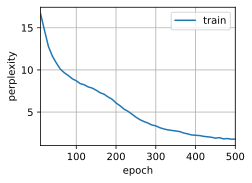

In [22]:
num_epochs, lr = 500, 0.2
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [23]:
# 训练之后的预测

d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time traveller pome an t'

# 6. 练习 

- 对于time machine，进行word级别的tokenize，使用rnn网络进行训练，并验证语言模型的效果